In [7]:
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
import matplotlib.pyplot as plt


%matplotlib inline

## Load Data: (32,32,3) Images

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

[7]


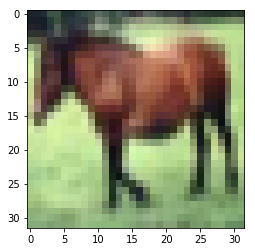

In [9]:
print(y_train[7])   #Convince yourself that the labels are consistent with the data.  See https://www.cs.toronto.edu/~kriz/cifar.html
plt.imshow(x_train[7,:,:,:])

## Clean Data:  Binary Reps. of Categories and Unrolling

In [10]:
x_train_unrolled = x_train.reshape(-1,32*32*3) / 256
print(x_train_unrolled.shape)
y_train_encoded = np_utils.to_categorical(y_train)

x_test_unrolled = x_test.reshape(-1,32*32*3) / 256
y_test_encoded = np_utils.to_categorical(y_test)

(50000, 3072)


## Create Unbiased Conv. NN

In [60]:
fresh = MobileNet(include_top = False, weights=None)
#fresh.summary()

## Add Adapters for Data Dimensions

In [61]:
rand_init_model = Sequential()

rand_init_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
rand_init_model.layers.extend(fresh.layers[1:])
rand_init_model.add(Dense(10,activation = 'softmax', name='cifar10_class_adapter'))

rand_init_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])





## Fit and Plot

In [62]:
%%time
history_fresh = rand_init_model.fit(x_train_unrolled,y_train_encoded, epochs=30)

Epoch 1/30
50000/50000 [==============================] - 19s 380us/step - loss: 1.8939 - acc: 0.3259
Epoch 2/30
50000/50000 [==============================] - 14s 274us/step - loss: 1.7615 - acc: 0.3717
Epoch 3/30
50000/50000 [==============================] - 14s 290us/step - loss: 1.7011 - acc: 0.3954
Epoch 4/30
50000/50000 [==============================] - 14s 290us/step - loss: 1.6578 - acc: 0.4102
Epoch 5/30
50000/50000 [==============================] - 15s 296us/step - loss: 1.6295 - acc: 0.4209
Epoch 6/30
50000/50000 [==============================] - 15s 292us/step - loss: 1.6076 - acc: 0.4288
Epoch 7/30
50000/50000 [==============================] - 15s 300us/step - loss: 1.5897 - acc: 0.4348
Epoch 8/30
50000/50000 [==============================] - 15s 299us/step - loss: 1.5741 - acc: 0.4394
Epoch 9/30
50000/50000 [==============================] - 15s 299us/step - loss: 1.5571 - acc: 0.4436
Epoch 10/30
50000/50000 [==============================] - 15s 306us/step - loss: 

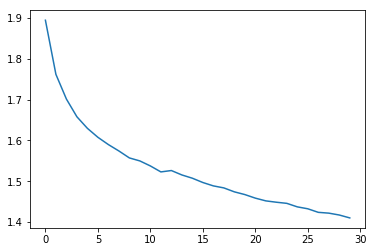

In [63]:
plt.plot(history_fresh.history['loss'])
#plt.plot(history_fresh.history['acc'])

## Create Biased Conv. NN

In [68]:
#Documentation for MobileNet says smaller shapes allowed, but throws error.  https://keras.io/applications/#mobilenet
#Thus, we have to adapt a new model to take the dimensions of our data (32,32,3).
#Initializing w/ input_shape will create input layer which we will later remove.  
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')

#Freeze: keep some pre-trained weights as they are.
#Try freezing other layers.
for layer in trained_model.layers:
    layer.trainable = False

#Check number of trainable parameters after freezing layers.
trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

In [69]:



#Create new model to add the trained model into.  
transfer_model = Sequential()
transfer_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
    
    
#Extend list of layers to include layers of trained_model, except for the first input layer.
#Check summary on model to see the layer structures.
#Remember, include_top = False has already chopped off the classification layers.
transfer_model.layers.extend(trained_model.layers[1:])
transfer_model.add(Dense(10, activation = 'softmax', name = 'cifar10_class_adapter'))

#Experiment: freeze all trainable params.  What do you expect to happen to the acc?  Check summary.
#transfer_model.trainable = False  


transfer_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])


In [70]:
#transfer_model.summary()

## Fit

In [71]:
%%time
history_transfer = transfer_model.fit(x_train_unrolled,y_train_encoded,epochs=30)

Epoch 1/30
50000/50000 [==============================] - 19s 382us/step - loss: 1.9428 - acc: 0.3048
Epoch 2/30
50000/50000 [==============================] - 13s 268us/step - loss: 1.8020 - acc: 0.3614
Epoch 3/30
50000/50000 [==============================] - 15s 306us/step - loss: 1.7409 - acc: 0.3804
Epoch 4/30
50000/50000 [==============================] - 14s 286us/step - loss: 1.7014 - acc: 0.3950
Epoch 5/30
50000/50000 [==============================] - 18s 360us/step - loss: 1.6670 - acc: 0.4085
Epoch 6/30
50000/50000 [==============================] - 14s 281us/step - loss: 1.6526 - acc: 0.4139
Epoch 7/30
50000/50000 [==============================] - 14s 285us/step - loss: 1.6291 - acc: 0.4213
Epoch 8/30
50000/50000 [==============================] - 14s 273us/step - loss: 1.6197 - acc: 0.4243
Epoch 9/30
50000/50000 [==============================] - 14s 271us/step - loss: 1.6036 - acc: 0.4295
Epoch 10/30
50000/50000 [==============================] - 14s 287us/step - loss: 

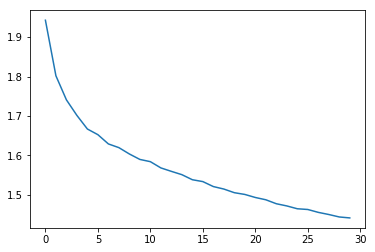

In [72]:
plt.plot(history_transfer.history['loss'])

In [ ]:
rand_init_model.predict